##### This project is aimed to predict the patients has COVID or not through provided CT image. Below is how the data looks like

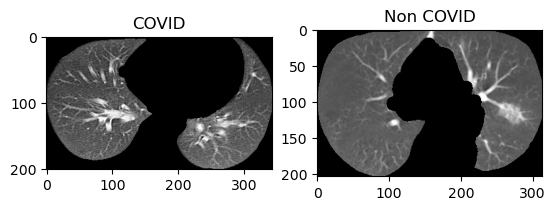

In [37]:
import matplotlib.pyplot as plt 
import matplotlib.image as img
import numpy as np
  
# reading the image 
no_cov_image = img.imread('local_traniner/input/test/nCoV/test-nCoV-000_series2_2_28.0.jpg')
cov_image = img.imread('local_traniner/input/test/no_nCoV/test-no_nCoV-000_1276254_CT_Chest Enhancement[20170629]-Series_005_Thorax  5.0  B70f-IMG00022.jpg')

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(cov_image)
ax2.imshow(no_cov_image)
ax1.title.set_text('COVID')
ax2.title.set_text('Non COVID')
plt.show()

### Dataset

In [ ]:
import os
import torchvision
import random
from PIL import Image
from torchvision import transforms
random.seed(0)

class CustomDataset(torchvision.datasets.VisionDataset):
    def __init__(self, root, is_train=True):
        super(CustomDataset, self).__init__(root, transforms=None)
        self.is_train = is_train
        self.file_lst, self.label_lst = [], []
        for label, folder in enumerate(['no_nCoV', 'nCoV']):
            path = os.path.join(root, folder)
            files = os.listdir(path)
            
            self.file_lst.extend(os.path.join(path, file) for file in files)
            self.label_lst.extend([label] * len(files))

        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.RandomHorizontalFlip() if is_train else transforms.Lambda(lambda x: x),
            transforms.ColorJitter(brightness=0.126, saturation=0.5) if is_train else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        file_path = self.file_lst[index]
        img = Image.open(file_path).convert('RGB')

        img = self.transform(img)
        label = self.label_lst[index]

        return img, label

    def __len__(self):
        return len(self.file_lst)

## Model Definition

##### In our model, we first apply Residual Networks **(ResNet)** with Feature Pyramid Networks **(FPN)**.
![FPN](FPN.png "FPN")
https://www.youtube.com/watch?v=FKsgO0U7CUw


##### For each level (there are 5 in this model), the **resnet_fpn_backbone()** will produce a 256 channels image then it will be sent into the **nn.Sequential()**. The image will firts be convoluted, Batch normalization, ReLU, then average pooling. The output will be **(1,2)** 

##### After finishing processing all levels, we will get **(5, 1, 2)** as the ouotput (5 levels, and each row contains 2 values, one is COVID the other is non-COVID). The last step is to apply self attention and softmax to calculate for appropriate weights and produce the output,

In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torch import nn

class DRE_net(nn.Module):
    def __init__(self, n_class):
        super(DRE_net, self).__init__()
        self.n_class = n_class

        self.backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone(backbone_name='resnet50', weights=ResNet50_Weights.DEFAULT)
        in_channels_list = [256, 256, 256, 256, 256]

        self.prediction_layers = nn.ModuleDict({
            str(i): nn.Sequential(
                nn.Conv2d(in_channels=in_channels_list[i], out_channels=n_class, kernel_size=1),
                nn.BatchNorm2d(n_class),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            ) for i in range(len(in_channels_list))
        })

        self.attention = nn.Linear(len(in_channels_list) * n_class, len(in_channels_list))

    def forward(self, x):
        feature_maps = self.backbone(x)

        preds = [self.prediction_layers[str(i)](feature_map) for i, feature_map in enumerate(feature_maps.values())]
        # Squeeze each tensor in preds
        preds = [p.view(p.size(0), -1) for p in preds]

        concatenated = torch.cat(preds, dim=1)

        # Predict the attention scores
        attn_scores = self.attention(concatenated)
        attn_weights = F.softmax(attn_scores, dim=1)

        # adjust shapes for both attn_weights and preds
        attn_weights = attn_weights.unsqueeze(-1)
        preds = torch.stack(preds, dim=1)

        # Sum the weighted preds
        output = (attn_weights * preds).sum(dim=1)

        return output

In [15]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from local_traniner.model.core.dataset import CustomDataset
from local_traniner.model.core.model import DRE_net

In [16]:
model_path = 'DRE-Net.pth'
best_model_path = 'BEST_DRE-Net.pth'

BATCH_SIZE = 4
EPOCHS = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    print()

train_path = os.path.join('local_traniner', 'input', 'train')
val_path = os.path.join('local_traniner', 'input', 'val')
test_path = os.path.join('local_traniner', 'input', 'test')

train_data = CustomDataset(root=train_path, is_train=True)
val_data = CustomDataset(root=val_path, is_train=False)
test_data = CustomDataset(root=test_path, is_train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)
test_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)


def calculate_accuracy(dataloader: DataLoader, model: nn.Module):
    correct = 0.
    total = 0.

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, pred = torch.max(outputs, 1)

            correct += (pred == labels).sum().cpu().numpy()
            total += labels.size(0)

    return 100 * correct / total

Using device: cuda

NVIDIA GeForce RTX 3070 Ti Laptop GPU
Memory Usage:
Allocated: 0.2 GB
Cached:    0.2 GB



In [18]:
model = DRE_net(n_class=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=1e-4)
best = float('-inf')
# checkpoint = torch.load(model_path)
# epoch = checkpoint['epoch']
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']
# val_accuracy = checkpoint['val_accuracy']
loss_log = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader)}")
    loss_log.append(running_loss / len(train_loader))

    if (epoch + 1) % 5 == 0:
        val_accuracy = calculate_accuracy(val_loader, model)
        print(f"Accuracy of the network on the val images: {val_accuracy:.1f} %")

        if val_accuracy > best:
            best = val_accuracy
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'val_accuracy': val_accuracy
        }, best_model_path)
            
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'val_accuracy': val_accuracy
        }, model_path)

test_accuracy = calculate_accuracy(test_loader, model)
print(f"Accuracy of the final network on the test images: {test_accuracy:.1f} %")

Epoch [1/30], Loss: 0.5974010230149126
Epoch [2/30], Loss: 0.5333049783307916
Epoch [3/30], Loss: 0.4696941920896856
Epoch [4/30], Loss: 0.4606979914554736
Epoch [5/30], Loss: 0.4396956813252346
Accuracy of the network on the val images: 90.5 %
Epoch [6/30], Loss: 0.40732476769424064
Epoch [7/30], Loss: 0.38212885564835647
Epoch [8/30], Loss: 0.36377576084398644
Epoch [9/30], Loss: 0.3491988864561822
Epoch [10/30], Loss: 0.3390932773931101
Accuracy of the network on the val images: 75.6 %
Epoch [11/30], Loss: 0.3902446105816638
Epoch [12/30], Loss: 0.3561269870151211
Epoch [13/30], Loss: 0.3402074338926671
Epoch [14/30], Loss: 0.3160816310719954
Epoch [15/30], Loss: 0.2738111034191444
Accuracy of the network on the val images: 97.0 %
Epoch [16/30], Loss: 0.28554764008376654
Epoch [17/30], Loss: 0.30403443450555984
Epoch [18/30], Loss: 0.2488749231299457
Epoch [19/30], Loss: 0.2949309121389007
Epoch [20/30], Loss: 0.2677265926806146
Accuracy of the network on the val images: 86.7 %
Epoc

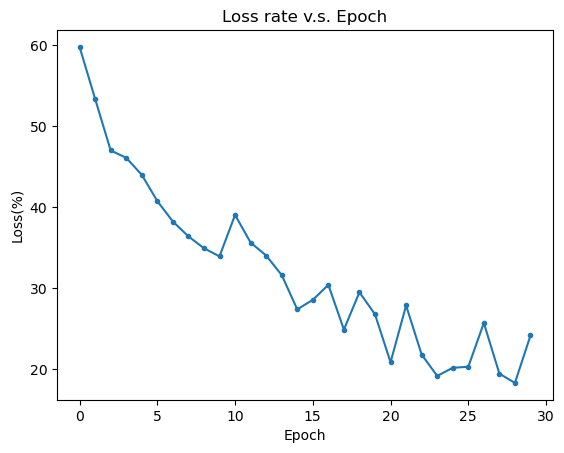

In [145]:
loss_output = [val*100 for val in loss_log]
plt.plot(range(len(loss_log)), loss_output, marker='.')
plt.title('Loss rate v.s. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss(%)')
plt.show()

##### Following block will load the model

In [146]:
checkpoint = torch.load(best_model_path)
#epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']
# val_accuracy = checkpoint['val_accuracy']

<All keys matched successfully>

In [147]:
val_accuracy = calculate_accuracy(val_loader, model)
val_accuracy

97.0383275261324